In [1]:
import sys
print(sys.executable)

/home/21101405/miniconda3/bin/python


In [2]:
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
import pandas as pd
import matplotlib.path as mpath
import matplotlib.patches as mpatches
import matplotlib.dates as mdates
import xarray as xr
from matplotlib.lines import Line2D
# To avoid warning messages
import warnings
warnings.filterwarnings('ignore')

In [3]:
sat_chl=xr.open_dataset("/A04/so_data/Trend_paper/CNN_training/obs/Same_grid_CHL_25km_masked.nc")
pred_chl= xr.open_mfdataset("/A04/so_data/Trend_paper/CNN_training/outputs/2025-05-16/15-41-35Chloro_pred/Chloro_pred_*.nc").load()

OSError: no files to open

In [ ]:
sat_chl=sat_chl.sel(time=pred_chl.time)
sat_chl

In [ ]:
pred_chl

In [ ]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

# Stack spatial dims for vectorized correlation
stacked_sat = sat_chl.stack(z=("latitude", "longitude"))
stacked_pred = pred_chl.stack(z=("latitude", "longitude"))

# Convert to numpy
x = stacked_sat.CHL.transpose("z", "time").values
y = stacked_pred.chloro_pred.transpose("z", "time").values

# Preallocate correlation array
corrs = np.full(x.shape[0], np.nan)

# Compute correlation across time for each spatial point
for i in range(x.shape[0]):
    xi = x[i]
    yi = y[i]
    mask = ~np.isnan(xi) & ~np.isnan(yi)
    if np.count_nonzero(mask) > 1:
        corrs[i] = np.corrcoef(xi[mask], yi[mask])[0, 1]

# Convert back to xarray
corr_map = xr.DataArray(corrs, coords=[stacked_sat["z"]]).unstack("z")

# Plot
plt.figure(figsize=(10, 5))
corr_map.plot(vmin=-1, vmax=1, cmap="RdBu_r")
plt.title("Correlation between CHL (satellite) and CHL (predicted)")
plt.show()

In [ ]:
def antarctic_map(ax):
    def plot_text(p1, p2, ax, ang_d, txt):
        l1 = np.array((p1[0], p1[1]))
        l2 = np.array((p2[0], p2[1]))
        th1 = ax.text(l1[0], l1[1], txt, fontsize=10,
                      transform=nonproj,
                      ha="center",
                      rotation=ang_d, rotation_mode='anchor')

    import cartopy.crs as ccrs
    nonproj = ccrs.PlateCarree()
    
    # Set the extent and add features
    ax.set_extent([-180, 180, -90, -30], nonproj)
    ax.add_feature(cfeature.LAND, color='darkgrey')
    ax.add_feature(cfeature.OCEAN, color='lightblue')
    ax.add_feature(cfeature.COASTLINE, linewidth=1.25)
    
    # Add gridlines with labels and custom style
    ax.gridlines(nonproj, draw_labels=False, linewidth=1, xlocs=range(-180, 171, 30), ylocs=[],
                  color='gray', alpha=0.5, linestyle='--', zorder=10)
    ax.gridlines(nonproj, draw_labels=True, linewidth=1, xlocs=[], ylocs=range(-90, -30, 10),
                  color='gray', alpha=0.5, linestyle='--', zorder=10)

    theta = np.linspace(0, 2 * np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax.set_boundary(circle, transform=ax.transAxes)

    for lon in range(-180, 180, 30):
        lat = -33  # determined by inspection

        a1, a2 = -29.5, -39  # text anchor for general use ...
        # ... need adjustments in some cases

        if lon >= 90 and lon <= 170:
            plot_text([lon, a1 + 2.35], [lon, a2], ax, -lon - 180, str(lon) + "°E")
            # Special rotation+shift
        elif lon < -90 and lon >= -170:
            # Need a1+2 to move texts in line with others
            plot_text([lon, a1 + 2.5], [lon, a2], ax, -lon + 180, str(-lon) + "°W")
            # Special rotation+shift
        elif lon > 0:
            plot_text([lon, a1], [lon, a2], ax, -lon, str(lon) + "°E")
        elif lon == 0:
            plot_text([lon, a1], [lon, a2], ax, lon, str(lon) + "°")
        elif lon == -180:
            plot_text([lon, a1 + 2.2], [lon, a2], ax, lon + 180, str(-lon) + "°")
        else:
            plot_text([lon, a1], [lon, a2], ax, -lon, str(-lon) + "°W")
            
            
    return ax

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
ax = plt.axes(projection=ccrs.SouthPolarStereo())
antarctic_map(ax)
# Plot using xarray's built-in plotting with matplotlib axis
corr_map.plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    vmin=-1,
    vmax=1,
    cmap="RdBu_r",
    cbar_kwargs={'label': 'Pearson correlation'}
)

plt.title("Correlation between CHL (satellite) and CHL (predicted)", pad= 30)
plt.tight_layout()
plt.show()

## Hovmoller plot

In [ ]:
print(sat_chl)
print(pred_chl)

In [ ]:
print(sat_chl)
print(pred_chl)
lon_90E = 90 # Longitude 90°E
pred_90E = pred_chl.sel(longitude=lon_90E, method='nearest')
# Determine color limits
colormax = np.round(np.nanmax(pred_90E.chloro_pred), 2)
colormin = np.round(np.nanmin(pred_90E.chloro_pred), 2)

# Set up the figure
fig = plt.figure(figsize=(10, 8))

# Set up the axes
ax = fig.add_subplot()

# Plot the Hovmöller plot (with time on x-axis and latitude on y-axis)
mm = ax.pcolormesh(pred_90E.latitude, pred_90E.time, pred_90E.chloro_pred, vmin=colormin, vmax=colormax, cmap='RdYlBu_r')

# Label and tidy up the plot
ax.grid(color='gray', linestyle='--', linewidth=1)
ax.set_xlabel("Time")
ax.set_ylabel("Latitude")
ax.set_title("Predicted CHL at 90°E from 2003-2023")

# Plot the colorbar
cbar = fig.colorbar(mm, orientation='vertical', pad=0.08, shrink=0.66, aspect=36)
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cmocean
import numpy as np
import colorcet as cc

def plot_chl_comparison(sat_chl, pred_chl, lon, di, basin):
    """
    Plot Hovmöller plots of satellite and predicted CHL at a specified longitude,
    and their difference.

    Parameters:
    -----------
    sat_chl : xarray.Dataset or xarray.DataArray
        Satellite CHL data with variable named 'CHL'
    pred_chl : xarray.Dataset or xarray.DataArray
        Predicted CHL data with variable named 'chloro_pred'
    elon : float
        Longitude value for extracting Hovmöller slice (e.g., 90 for 90°E)
    """
    # Extract Hovmöller slices
    sat_1d = sat_chl.sel(longitude=lon, method='nearest')
    pred_1d = pred_chl.sel(longitude=lon, method='nearest')

    # Difference
    diff = pred_1d.chloro_pred - sat_1d.CHL

    # Set color limits for CHL
    chl_min = 0.01
    chl_max = 10
    diff_min, diff_max = -1, 1  # Customize if needed

    # ---- PLOT: 3-Panel Hovmöller ----
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(24, 10), dpi=100, constrained_layout=True)

    # Panel 1: Satellite CHL
    pcm1 = ax[0].pcolormesh(
        sat_1d.latitude, sat_1d.time, sat_1d.CHL,
        cmap=cc.cm["rainbow"], norm=colors.LogNorm(vmin=chl_min, vmax=chl_max), shading='auto'
    )
    ax[0].set_title(f"Satellite CHL at {lon}°{di}")
    ax[0].set_ylabel("Time")
    ax[0].set_xlabel("Latitude")
    fig.colorbar(pcm1, ax=ax[0], orientation='vertical', pad=0.02, label='mg/m³')

    # Panel 2: Predicted CHL
    pcm2 = ax[1].pcolormesh(
        pred_1d.latitude, pred_1d.time, pred_1d.chloro_pred,
        cmap=cc.cm["rainbow"], norm=colors.LogNorm(vmin=chl_min, vmax=chl_max), shading='auto'
    )
    ax[1].set_title(f"Predicted CHL at {lon}°{di}")
    ax[1].set_xlabel("Latitude")
    fig.colorbar(pcm2, ax=ax[1], orientation='vertical', pad=0.02, label='mg/m³')

    # Panel 3: Difference
    pcm3 = ax[2].pcolormesh(
        diff.latitude, diff.time, diff,
        cmap=cmocean.cm.balance, vmin=diff_min, vmax=diff_max, shading='auto'
    )
    ax[2].set_title("CHL Difference (Pred - Sat)")
    ax[2].set_xlabel("Latitude")
    fig.colorbar(pcm3, ax=ax[2], orientation='vertical', pad=0.02, label='mg/m³')

    for axis in ax:
        axis.grid(True, linestyle='--', color='gray', linewidth=0.5)

    plt.suptitle(f"Hovmöller Comparison at {lon}°{di}-{basin}", fontsize=14)
    plt.show()

In [ ]:
plot_chl_comparison(sat_chl=sat_chl, pred_chl=pred_chl, lon=90, di='E', basin='Indian')

In [ ]:
plot_chl_comparison(sat_chl=sat_chl, pred_chl=pred_chl, lon=-30, di='W', basin='Atlantic')

In [ ]:
plot_chl_comparison(sat_chl=sat_chl, pred_chl=pred_chl, lon=-150, di='W', basin='Pacific')

In [ ]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

# Load the dataset
input_ds = xr.open_dataset("/A04/so_data/Trend_paper/CNN_training/obs/input_ds_sst_mld_ws_par_masked_time.nc")

# Variable names to plot
var_names = ['sst', 'mlotst', 'wind_speed', 'par']
titles = ['Sea Surface Temperature (°C)', 'Mixed Layer Depth (m)', 'Wind Speed (m/s)', 'Photosynthetically Active Radiation (Einstein/m2)']
lon_90E = 90  # Longitude 90°E

# Set up the 2x2 figure
fig, axes = plt.subplots(2, 2, figsize=(15, 12), sharex=True, constrained_layout=True)
axes = axes.flatten()  # <-- flatten 2x2 array to 1D array of axes

for i, var in enumerate(var_names):
    # Extract variable at 90°E
    var_data = input_ds[var].sel(longitude=lon_90E, method='nearest')

    # Color limits
    vmin = np.nanpercentile(var_data, 2)
    vmax = np.nanpercentile(var_data, 98)

    # Plot Hovmöller diagram
    pcm = axes[i].pcolormesh(var_data.latitude, var_data.time, var_data.transpose('time', 'latitude'),
                             cmap='RdYlBu_r', vmin=vmin, vmax=vmax, shading='auto')

    axes[i].set_title(titles[i])
    axes[i].set_ylabel("Time")
    axes[i].grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

    cbar = fig.colorbar(pcm, ax=axes[i], orientation='vertical', pad=0.01, shrink=0.8)
    cbar.ax.set_ylabel(var)

axes[-1].set_xlabel("Time")
plt.suptitle("Hovmöller Plots at 90°E for Model Input Variables (Indian)", fontsize=16, y=1.02)
plt.show()

In [ ]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

# Load the dataset
input_ds = xr.open_dataset("/A04/so_data/Trend_paper/CNN_training/obs/input_ds_sst_mld_ws_par_masked_time.nc")

# Variable names to plot
var_names = ['sst', 'mlotst', 'wind_speed', 'par']
titles = ['Sea Surface Temperature (°C)', 'Mixed Layer Depth (m)', 'Wind Speed (m/s)', 'Photosynthetically Active Radiation (Einstein/m2)']
lon_90E = -30  # Longitude 90°E

# Set up the 2x2 figure
fig, axes = plt.subplots(2, 2, figsize=(15, 12), sharex=True, constrained_layout=True)
axes = axes.flatten()  # <-- flatten 2x2 array to 1D array of axes

for i, var in enumerate(var_names):
    # Extract variable at 90°E
    var_data = input_ds[var].sel(longitude=lon_90E, method='nearest')

    # Color limits
    vmin = np.nanpercentile(var_data, 2)
    vmax = np.nanpercentile(var_data, 98)

    # Plot Hovmöller diagram
    pcm = axes[i].pcolormesh(var_data.latitude, var_data.time, var_data.transpose('time', 'latitude'),
                             cmap='RdYlBu_r', vmin=vmin, vmax=vmax, shading='auto')

    axes[i].set_title(titles[i])
    axes[i].set_ylabel("Time")
    axes[i].grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

    cbar = fig.colorbar(pcm, ax=axes[i], orientation='vertical', pad=0.01, shrink=0.8)
    cbar.ax.set_ylabel(var)

axes[-1].set_xlabel("Time")
plt.suptitle("Hovmöller Plots at 30°W for Model Input Variables (Atlantic)", fontsize=16, y=1.02)
plt.show()

In [ ]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

# Load the dataset
input_ds = xr.open_dataset("/A04/so_data/Trend_paper/CNN_training/obs/input_ds_sst_mld_ws_par_masked_time.nc")

# Variable names to plot
var_names = ['sst', 'mlotst', 'wind_speed', 'par']
titles = ['Sea Surface Temperature (°C)', 'Mixed Layer Depth (m)', 'Wind Speed (m/s)', 'Photosynthetically Active Radiation (Einstein/m2)']
lon_90E = -150  # Longitude 90°E

# Set up the 2x2 figure
fig, axes = plt.subplots(2, 2, figsize=(15, 12), sharex=True, constrained_layout=True)
axes = axes.flatten()  # <-- flatten 2x2 array to 1D array of axes

for i, var in enumerate(var_names):
    # Extract variable at 90°E
    var_data = input_ds[var].sel(longitude=lon_90E, method='nearest')

    # Color limits
    vmin = np.nanpercentile(var_data, 2)
    vmax = np.nanpercentile(var_data, 98)

    # Plot Hovmöller diagram
    pcm = axes[i].pcolormesh(var_data.latitude, var_data.time, var_data.transpose('time', 'latitude'),
                             cmap='RdYlBu_r', vmin=vmin, vmax=vmax, shading='auto')

    axes[i].set_title(titles[i])
    axes[i].set_ylabel("Time")
    axes[i].grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

    cbar = fig.colorbar(pcm, ax=axes[i], orientation='vertical', pad=0.01, shrink=0.8)
    cbar.ax.set_ylabel(var)

axes[-1].set_xlabel("Time")
plt.suptitle("Hovmöller Plots at 150°W for Model Input Variables (Pacific)", fontsize=16, y=1.02)
plt.show()

### Scatter plot

In [ ]:
sat_chl=xr.open_dataset("/A04/so_data/Trend_paper/CNN_training/obs/Same_grid_CHL_25km_masked.nc")
pred_chl= xr.open_mfdataset("/A04/so_data/Trend_paper/CNN_training/outputs/2025-05-16_3D_Mask_ASloss//15-41-35Chloro_pred/Chloro_pred_*.nc").load()
sat_chl=sat_chl.sel(time=pred_chl.time)

In [ ]:
lon_90E = 90
sat_90E = sat_chl.sel(longitude=lon_90E, method='nearest')
pred_90E = pred_chl.sel(longitude=lon_90E, method='nearest')

In [ ]:
sat_90E.CHL[0]

In [ ]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde, linregress
from sklearn.metrics import mean_squared_error

lon_90E = 90
sat_90E = sat_chl.sel(longitude=lon_90E, method='nearest')
pred_90E = pred_chl.sel(longitude=lon_90E, method='nearest')
# Flatten and clean
sat_flat = sat_90E.CHL.values.flatten()
pred_flat = pred_90E.chloro_pred.values.flatten()
mask = ~np.isnan(sat_flat) & ~np.isnan(pred_flat)
sat_clean = sat_flat[mask]
pred_clean = pred_flat[mask]

# Log transform (avoid log(0))
sat_log = np.log10(sat_clean + 1e-6)
pred_log = np.log10(pred_clean + 1e-6)

# --- Compute stats ---
slope, intercept, r_value, p_value, std_err = linregress(sat_log, pred_log)
rmse = np.sqrt(mean_squared_error(sat_log, pred_log))
r2 = r_value**2

# --- Density estimation ---
xy = np.vstack([sat_log, pred_log])
z = gaussian_kde(xy)(xy)
idx = z.argsort()
x_sorted, y_sorted, z_sorted = sat_log[idx], pred_log[idx], z[idx]

# --- Plot ---
fig, ax = plt.subplots(figsize=(7, 6))
sc = ax.scatter(x_log, y_log, c=density, s=5, cmap='jet', norm=plt.Normalize(vmin=1e0, vmax=1e2))

# 1:1 Line
min_val = min(sat_log.min(), pred_log.min())
max_val = max(sat_log.max(), pred_log.max())
ax.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='1:1 Line')

# Regression Line
x_fit = np.array([min_val, max_val])
y_fit = slope * x_fit + intercept
ax.plot(x_fit, y_fit, color='black', linestyle='-', label='Regression Line')

# Text box
textstr = '\n'.join((
    r'$R^2=%.2f$' % r2,
    r'$RMSE=%.2f$' % rmse,
    r'$Slope=%.2f$' % slope,
))
plt.text(min_val + 0.05, max_val - 0.3, textstr, fontsize=12, va='top')

# Formatting
plt.xlabel("Log10(Satellite CHL) [mg/m³]")
plt.ylabel("Log10(Predicted CHL) [mg/m³]")
plt.title("Scatter Plot of CHL at 90°E (Indian)")
cb = fig.colorbar(sc, ax=ax)
cb.set_label("Point Density")
cb.ax.set_yscale('log')
cb.set_ticks([1e0, 1e1, 1e2])  # show 10⁰, 10¹, etc.
cb.ax.set_yticklabels([r'$10^0$', r'$10^1$', r'$10^2$'])
cbar.set_label("Point Density")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde, linregress
from sklearn.metrics import mean_squared_error

lon_90E = -30
sat_90E = sat_chl.sel(longitude=lon_90E, method='nearest')
pred_90E = pred_chl.sel(longitude=lon_90E, method='nearest')
# Flatten and clean
sat_flat = sat_90E.CHL.values.flatten()
pred_flat = pred_90E.chloro_pred.values.flatten()
mask = ~np.isnan(sat_flat) & ~np.isnan(pred_flat)
sat_clean = sat_flat[mask]
pred_clean = pred_flat[mask]

# Log transform (avoid log(0))
sat_log = np.log10(sat_clean + 1e-6)
pred_log = np.log10(pred_clean + 1e-6)

# --- Compute stats ---
slope, intercept, r_value, p_value, std_err = linregress(sat_log, pred_log)
rmse = np.sqrt(mean_squared_error(sat_log, pred_log))
r2 = r_value**2

# --- Density estimation ---
xy = np.vstack([sat_log, pred_log])
z = gaussian_kde(xy)(xy)
idx = z.argsort()
x_sorted, y_sorted, z_sorted = sat_log[idx], pred_log[idx], z[idx]

# --- Plot ---
fig, ax = plt.subplots(figsize=(7, 6))
sc = ax.scatter(x_log, y_log, c=density, s=5, cmap='jet', norm=plt.Normalize(vmin=1e0, vmax=1e2))

# 1:1 Line
min_val = min(sat_log.min(), pred_log.min())
max_val = max(sat_log.max(), pred_log.max())
ax.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='1:1 Line')

# Regression Line
x_fit = np.array([min_val, max_val])
y_fit = slope * x_fit + intercept
ax.plot(x_fit, y_fit, color='black', linestyle='-', label='Regression Line')

# Text box
textstr = '\n'.join((
    r'$R^2=%.2f$' % r2,
    r'$RMSE=%.2f$' % rmse,
    r'$Slope=%.2f$' % slope,
))
plt.text(min_val + 0.05, max_val - 0.3, textstr, fontsize=12, va='top')

# Formatting
plt.xlabel("Log10(Satellite CHL) [mg/m³]")
plt.ylabel("Log10(Predicted CHL) [mg/m³]")
plt.title("Scatter Plot of CHL at 30°W (Atlantic)")
cb = fig.colorbar(sc, ax=ax)
cb.set_label("Point Density")
cb.ax.set_yscale('log')
cb.set_ticks([1e0, 1e1, 1e2])  # show 10⁰, 10¹, etc.
cb.ax.set_yticklabels([r'$10^0$', r'$10^1$', r'$10^2$'])
cbar.set_label("Point Density")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde, linregress
from sklearn.metrics import mean_squared_error

lon_90E = -150
sat_90E = sat_chl.sel(longitude=lon_90E, method='nearest')
pred_90E = pred_chl.sel(longitude=lon_90E, method='nearest')
# Flatten and clean
sat_flat = sat_90E.CHL.values.flatten()
pred_flat = pred_90E.chloro_pred.values.flatten()
mask = ~np.isnan(sat_flat) & ~np.isnan(pred_flat)
sat_clean = sat_flat[mask]
pred_clean = pred_flat[mask]

# Log transform (avoid log(0))
sat_log = np.log10(sat_clean + 1e-6)
pred_log = np.log10(pred_clean + 1e-6)

# --- Compute stats ---
slope, intercept, r_value, p_value, std_err = linregress(sat_log, pred_log)
rmse = np.sqrt(mean_squared_error(sat_log, pred_log))
r2 = r_value**2

# --- Density estimation ---
xy = np.vstack([sat_log, pred_log])
z = gaussian_kde(xy)(xy)
idx = z.argsort()
x_sorted, y_sorted, z_sorted = sat_log[idx], pred_log[idx], z[idx]

# --- Plot ---
fig, ax = plt.subplots(figsize=(7, 6))
sc = ax.scatter(x_log, y_log, c=density, s=5, cmap='jet', norm=plt.Normalize(vmin=1e0, vmax=1e2))

# 1:1 Line
min_val = min(sat_log.min(), pred_log.min())
max_val = max(sat_log.max(), pred_log.max())
ax.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='1:1 Line')

# Regression Line
x_fit = np.array([min_val, max_val])
y_fit = slope * x_fit + intercept
ax.plot(x_fit, y_fit, color='black', linestyle='-', label='Regression Line')

# Text box
textstr = '\n'.join((
    r'$R^2=%.2f$' % r2,
    r'$RMSE=%.2f$' % rmse,
    r'$Slope=%.2f$' % slope,
))
plt.text(min_val + 0.05, max_val - 0.3, textstr, fontsize=12, va='top')

# Formatting
plt.xlabel("Log10(Satellite CHL) [mg/m³]")
plt.ylabel("Log10(Predicted CHL) [mg/m³]")
plt.title("Scatter Plot of CHL at 150°W (Pacific)")
cb = fig.colorbar(sc, ax=ax)
cb.set_label("Point Density")
cb.ax.set_yscale('log')
cb.set_ticks([1e0, 1e1, 1e2])  # show 10⁰, 10¹, etc.
cb.ax.set_yticklabels([r'$10^0$', r'$10^1$', r'$10^2$'])
cbar.set_label("Point Density")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [ ]:
len(sat_flat)

In [ ]:
len(sat_clean)

#### Mean and Standard deviation of the plot

In [ ]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cmocean
import colorcet as cc

# Load and rename
y_test = xr.open_dataset("/A04/so_data/Trend_paper/CNN_training/obs/Same_grid_CHL_25km.nc")
y_test = y_test.rename({'CHL': 'chloro'})

y_pred = xr.open_mfdataset('/A04/so_data/Trend_paper/CNN_training/outputs/2025-05-05/13-55-28/Chloro_pred/Chloro_pred_*.nc')

# Compute time-averaged chlorophyll
sat_chloro_mean = y_test.chloro.mean(dim="time")
pred_chloro_mean = y_pred.chloro_pred.mean(dim="time")

# Set color maps
cm = cc.cm["rainbow"]

# Plot mean CHL and difference
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18,9), dpi=80, facecolor='w', edgecolor='k', subplot_kw={'projection': ccrs.SouthPolarStereo()})
for a in ax:
    antarctic_map(a)
# Plot satellite mean
sat_chloro_mean.plot(ax=ax[0], cmap=cm, norm=colors.LogNorm(vmin=0.01, vmax=10), transform=ccrs.PlateCarree(), 
                     cbar_kwargs={"orientation": "horizontal", "pad": 0.05, "shrink": 0.8, "label": "Chl-a Sat"})
ax[0].set_title("Satellite CHL Mean",  pad=20)

# Plot predicted mean
pred_chloro_mean.plot(ax=ax[1], cmap=cm, norm=colors.LogNorm(vmin=0.01, vmax=10), transform=ccrs.PlateCarree(), 
                     cbar_kwargs={"orientation": "horizontal", "pad": 0.05, "shrink": 0.8, "label": "Chl-a Pred"})
ax[1].set_title("Predicted CHL Mean",  pad=20)

# Plot difference
(pred_chloro_mean - sat_chloro_mean).plot(ax=ax[2], cmap=cmocean.cm.balance, vmin=-1, vmax=1, transform=ccrs.PlateCarree(), 
                     cbar_kwargs={"orientation": "horizontal", "pad": 0.05, "shrink": 0.8})
ax[2].set_title("CHL Difference (Pred - Sat)", pad=20)

plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
import pandas as pd
# Define the color map
color_values = [
    [147,0,108], [111,0,144], [72,0,183], [33,0,222], [0,10,255], [0,74,255],
    [0,144,255], [0,213,255], [0,255,215], [0,255,119], [0,255,15], [96,255,0],
    [200,255,0], [255,235,0], [255,183,0], [255,131,0], [255,79,0], [255,31,0],
    [230,0,0], [165,0,0], [105,0,0]
]
sample_values = [0.0105927390978, 0.01511153517746066, 0.02218493234759939,
                 0.03259381777070279, 0.047886418593687446, 0.06831451603621097,
                 0.10029112852033921, 0.1473464383750438, 0.2164794954661175,
                 0.30882852380362497, 0.4533847704508146, 0.6661070836975002,
                 0.9786359751581525, 1.3961169989723918, 2.049610500045872,
                 3.011261431529367, 4.424106633340013, 6.311407543621453,
                 9.265646919990738, 13.612969492356, 20.0]
cmap = colors.ListedColormap(np.array(color_values)/255.0)
norm = colors.BoundaryNorm(sample_values, len(sample_values))

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18,9), dpi=80, facecolor='w', edgecolor='k', subplot_kw={'projection': ccrs.SouthPolarStereo()})
for a in ax:
    antarctic_map(a)
# Plot satellite mean
sat_chloro_mean.plot(ax=ax[0], cmap=cmap, norm=norm, transform=ccrs.PlateCarree(), 
                     cbar_kwargs={"orientation": "horizontal", "pad": 0.05, "shrink": 0.8, "label": "Chl-a Sat"})
ax[0].set_title("Satellite CHL Mean",  pad=20)

# Plot predicted mean
pred_chloro_mean.plot(ax=ax[1], cmap=cmap, norm=norm, transform=ccrs.PlateCarree(), 
                     cbar_kwargs={"orientation": "horizontal", "pad": 0.05, "shrink": 0.8, "label": "Chl-a Pred"})
ax[1].set_title("Predicted CHL Mean",  pad=20)

# Plot difference
(pred_chloro_mean - sat_chloro_mean).plot(ax=ax[2], cmap=cmocean.cm.balance, vmin=-1, vmax=1, transform=ccrs.PlateCarree(), 
                     cbar_kwargs={"orientation": "horizontal", "pad": 0.05, "shrink": 0.8})
ax[2].set_title("CHL Difference (Pred - Sat)", pad=20)

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cmocean
import colorcet as cc
import cartopy.crs as ccrs

# Compute std deviation
sat_chloro_std = y_test.chloro.std(dim="time")
pred_chloro_std = y_pred.chloro_pred.std(dim="time")

# Set colormap
cm = cc.cm["rainbow"]

# Create plot
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18, 9), dpi=80, facecolor='w', edgecolor='k',
                       subplot_kw={'projection': ccrs.SouthPolarStereo()})

for a in ax:
    antarctic_map(a)  # Assuming you already defined this to add land, coastlines, etc.

# Satellite std plot
sat_chloro_std.plot(ax=ax[0], cmap=cm, norm=colors.LogNorm(vmin=0.001, vmax=5), transform=ccrs.PlateCarree(),
                    cbar_kwargs={"orientation": "horizontal", "pad": 0.05, "shrink": 0.8, "label": "CHL Std Sat"})
ax[0].set_title("Satellite CHL Std Dev", pad=20)

# Prediction std plot
pred_chloro_std.plot(ax=ax[1], cmap=cm, norm=colors.LogNorm(vmin=0.001, vmax=5), transform=ccrs.PlateCarree(),
                     cbar_kwargs={"orientation": "horizontal", "pad": 0.05, "shrink": 0.8, "label": "CHL Std Pred"})
ax[1].set_title("Predicted CHL Std Dev", pad=20)

# Difference plot
(pred_chloro_std - sat_chloro_std).plot(ax=ax[2], cmap=cmocean.cm.balance, vmin=-1, vmax=1, transform=ccrs.PlateCarree(),
                                        cbar_kwargs={"orientation": "horizontal", "pad": 0.05, "shrink": 0.8})
ax[2].set_title("CHL Std Diff (Pred - Sat)", pad=20)

plt.tight_layout()
plt.show()

In [ ]:
sat_chloro_mean = y_test.mean(dim = ("time"))
pred_chloro_mean = y_pred.mean(dim = ["time"])

In [ ]:
import cmocean
import colorcet as cc
cm = cc.cm["rainbow"]
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20,3), dpi=80, facecolor='w', edgecolor='k')
y_pred.chloro_pred.plot(ax = ax[1],cmap = cm,norm=colors.LogNorm(vmin=0.01, vmax=10))
y_test.chloro.plot(ax = ax[0],cmap = cm,norm=colors.LogNorm(vmin=0.01, vmax=10))
    
ax[0].set_title('Chloro' + str(y_pred.time.data).split('T')[0])
ax[1].set_title('Chloro pred, ' + str(y_pred.time.data).split('T')[0])

(y_pred.chloro_pred-y_test.chloro).plot(ax = ax[2],cmap = cmocean.cm.balance,vmin = -1,vmax = 1)
ax[2].set_title('Chloro pred' + str(y_pred.time.data).split('T')[0])

### loss comparasion

In [ ]:
import numpy as np
import xarray as xr
import pandas as pd
import glob
import matplotlib.pyplot as plt

In [ ]:
ls -l /A04/so_data/Trend_paper/CNN_training/outputs/2025-05-15_3DMask_MSEloss

In [ ]:
ls -l /A04/so_data/Trend_paper/CNN_training/outputs/2025-05-16_3D_Mask_ASloss

In [ ]:
import glob
import numpy as np
import matplotlib.pyplot as plt
import os

# Define the folders
folder_mse = "/A04/so_data/Trend_paper/CNN_training/outputs/2025-05-15_3DMask_MSEloss"
folder_asm = "/A04/so_data/Trend_paper/CNN_training/outputs/2025-05-16_3D_Mask_ASloss"

# Define prefixes (from your filenames)
prefixes = ['19-17-10', '15-41-35']
folders = [folder_mse, folder_asm]
labels = ['MSE', 'AS']

# Plot
plt.figure(figsize=(10, 6))
for i, (folder, prefix, label) in enumerate(zip(folders, prefixes, labels)):
    train_path = os.path.join(folder, f"{prefix}train_loss.npy")
    valid_path = os.path.join(folder, f"{prefix}valid_loss.npy")
    
    if not os.path.exists(train_path) or not os.path.exists(valid_path):
        print(f"❌ Missing loss file(s) in: {folder} with prefix {prefix}")
        continue
    
    train_loss = np.load(train_path)
    valid_loss = np.load(valid_path)

    plt.plot(train_loss, label=f'{label} Train', linestyle='--')
    plt.plot(valid_loss, label=f'{label} Valid')

plt.title("Train and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import os

# Define paths
log_MSE = "/A04/so_data/Trend_paper/CNN_training/outputs/2025-05-15_3DMask_MSEloss/*train_loss.npy"
log_ASM = "/A04/so_data/Trend_paper/CNN_training/outputs/2025-05-16_3D_Mask_ASloss/*train_loss.npy"

# Find all matching train_loss files
list_MSE_train = sorted(glob.glob(log_MSE))
list_ASM_train = sorted(glob.glob(log_ASM))

# Derive valid_loss paths from train_loss paths
list_MSE_Loss = [(train, train.replace("train_loss", "valid_loss")) for train in list_MSE_train]
list_ASM_Loss = [(train, train.replace("train_loss", "valid_loss")) for train in list_ASM_train]

# Prepare the plot
tt = ['MSE Loss', 'ASM Loss']
fig, ax = plt.subplots(1, 2, figsize=(14, 5), sharey=True, tight_layout=True)

# Loop over MSE and ASM lists
for k, loss_list in enumerate([list_MSE_Loss, list_ASM_Loss]):
    for i, (train_path, valid_path) in enumerate(loss_list):
        try:
            tra = np.load(train_path)
            val = np.load(valid_path)
        except FileNotFoundError:
            print(f"Missing file(s): {train_path} or {valid_path}")
            continue

        if i == 0:
            ax[k].plot(val, label='Validation loss', color='tab:orange')
            ax[k].plot(tra, label='Training loss', color='tab:blue')
        else:
            ax[k].plot(val, color='tab:orange')
            ax[k].plot(tra, color='tab:blue')

    ax[k].set_title(tt[k])
    ax[k].grid()
    ax[k].set_xlabel('Epochs')
    ax[k].set_ylabel('Loss')

# One legend for all
plt.legend(frameon=False, loc='upper right')
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import os

# Define paths
log_MSE = "/A04/so_data/Trend_paper/CNN_training/outputs/2025-05-17/*train_loss.npy"
log_ASM = "/A04/so_data/Trend_paper/CNN_training/outputs/2025-05-18/*train_loss.npy"

# Find all matching train_loss files
list_MSE_train = sorted(glob.glob(log_MSE))
list_ASM_train = sorted(glob.glob(log_ASM))

# Derive valid_loss paths from train_loss paths
list_MSE_Loss = [(train, train.replace("train_loss", "valid_loss")) for train in list_MSE_train]
list_ASM_Loss = [(train, train.replace("train_loss", "valid_loss")) for train in list_ASM_train]

# Prepare the plot
tt = ['MSE Loss', 'ASM Loss']
fig, ax = plt.subplots(1, 2, figsize=(14, 5), sharey=True, tight_layout=True)

# Loop over MSE and ASM lists
for k, loss_list in enumerate([list_MSE_Loss, list_ASM_Loss]):
    for i, (train_path, valid_path) in enumerate(loss_list):
        try:
            tra = np.load(train_path)
            val = np.load(valid_path)
        except FileNotFoundError:
            print(f"Missing file(s): {train_path} or {valid_path}")
            continue

        if i == 0:
            ax[k].plot(val, label='Validation loss', color='tab:orange')
            ax[k].plot(tra, label='Training loss', color='tab:blue')
        else:
            ax[k].plot(val, color='tab:orange')
            ax[k].plot(tra, color='tab:blue')

    ax[k].set_title(tt[k])
    ax[k].grid()
    ax[k].set_xlabel('Epochs')
    ax[k].set_ylabel('Loss')

# One legend for all
plt.legend(frameon=False, loc='upper right')
plt.show()

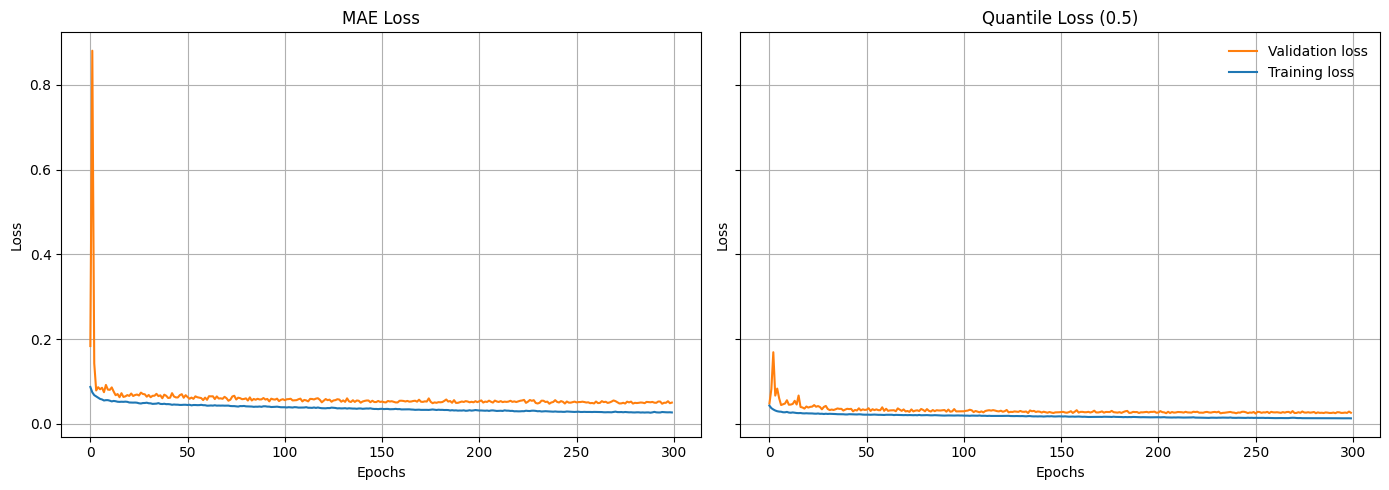

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import os

# Define paths
log_MSE = "/A04/so_data/Trend_paper/CNN_training/outputs/2025-05-23/*train_loss.npy"
log_ASM = "/A04/so_data/Trend_paper/CNN_training/outputs/2025-05-27/*train_loss.npy"

# Find all matching train_loss files
list_MSE_train = sorted(glob.glob(log_MSE))
list_ASM_train = sorted(glob.glob(log_ASM))

# Derive valid_loss paths from train_loss paths
list_MSE_Loss = [(train, train.replace("train_loss", "valid_loss")) for train in list_MSE_train]
list_ASM_Loss = [(train, train.replace("train_loss", "valid_loss")) for train in list_ASM_train]

# Prepare the plot
tt = ['MAE Loss', 'Quantile Loss (0.5)']
fig, ax = plt.subplots(1, 2, figsize=(14, 5), sharey=True, tight_layout=True)

# Loop over MSE and ASM lists
for k, loss_list in enumerate([list_MSE_Loss, list_ASM_Loss]):
    for i, (train_path, valid_path) in enumerate(loss_list):
        try:
            tra = np.load(train_path)
            val = np.load(valid_path)
        except FileNotFoundError:
            print(f"Missing file(s): {train_path} or {valid_path}")
            continue

        if i == 0:
            ax[k].plot(val, label='Validation loss', color='tab:orange')
            ax[k].plot(tra, label='Training loss', color='tab:blue')
        else:
            ax[k].plot(val, color='tab:orange')
            ax[k].plot(tra, color='tab:blue')

    ax[k].set_title(tt[k])
    ax[k].grid()
    ax[k].set_xlabel('Epochs')
    ax[k].set_ylabel('Loss')

# One legend for all
plt.legend(frameon=False, loc='upper right')
plt.show()

#### normality Check

In [ ]:
sat_chl=xr.open_dataset("/A04/so_data/Trend_paper/CNN_training/obs/Same_grid_CHL_25km_masked.nc")
sat_chl